In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

import numpy as np
# from utils import adata_train

import scanpy as sc 
adata_train = sc.read_h5ad('./.cache/adata_train.h5ad')

In [3]:
'Pax5' in adata_train.var_names

True

In [4]:
adata_train.shape

(10277, 2833)

In [5]:
from tqdm import tqdm
import pandas as pd

import celloracle as co

which: no R in (/ix/djishnu/alw399/envs/bee/bin:/ix/djishnu/alw399/envs/bee/bin:/ihome/crc/install/python/ondemand-jupyter-python3.10-2023.03/condabin:/ihome/crc/install/ondemand/code-server/code-server-4.5.1-linux-amd64/lib/vscode/bin/remote-cli:/ihome/crc/install/python/ondemand-jupyter-python3.10-2023.03/bin:/ihome/crc/install/ondemand/code-server/code-server-4.5.1-linux-amd64/bin:/ihome/crc/install/git/2.33.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/bedtools2-2.30.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/bedtools2-2.30.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/b

In [6]:
import spaceoracle

so = spaceoracle.SpaceOracle(
    adata=adata_train,
    annot='rctd_cluster', 
    max_epochs=1, 
    learning_rate=7e-4, 
    spatial_dim=64,
    batch_size=256,
    init_betas='zeros',
    rotate_maps=True,
    cluster_grn=True,
    regularize=True,
)

so.cluster_column_name = 'rctd_cluster'

In [7]:
import pickle 

with open('beta_dict.pickle', 'rb') as handle:
    so.beta_dict = pickle.load(handle)
so.coef_matrix = pd.read_csv('coef_matrix.csv', index_col=0)

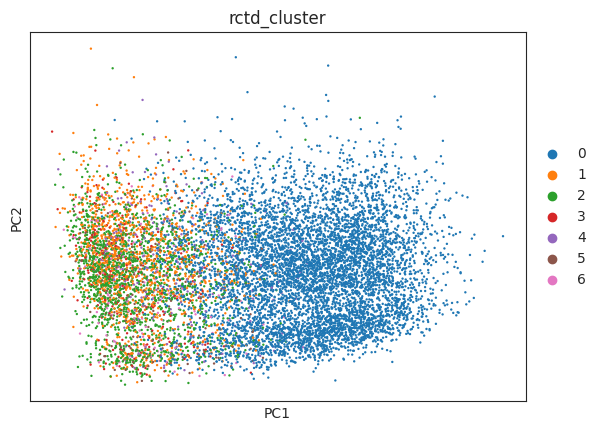

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

sc.tl.pca(adata_train)
sc.pl.pca(adata_train, color='rctd_cluster', layer='imputed_count')

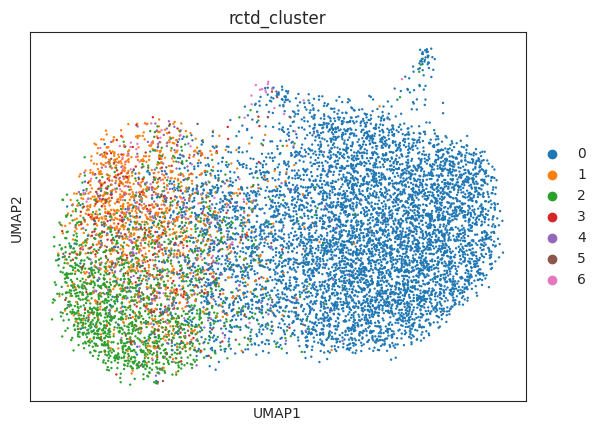

In [18]:
sc.tl.umap(adata_train)
sc.pl.umap(adata_train, color='rctd_cluster', layer='imputed_count')

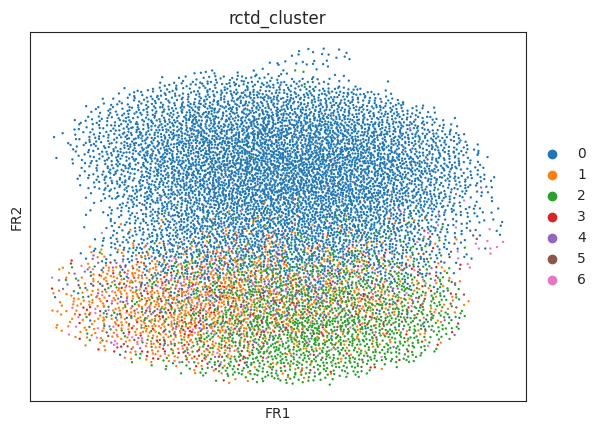

In [19]:
sc.tl.draw_graph(adata_train, layout='fa', init_pos='paga', random_state=123)
sc.pl.draw_graph(adata_train, color='rctd_cluster')

In [24]:
so.adata = adata_train

In [25]:
so.embedding_name = 'X_draw_graph_fr'
so.embedding = so.adata.obsm['X_draw_graph_fr']
so.cluster_column_name = 'rctd_cluster'

In [26]:
from celloracle.applications import Pseudotime_calculator

# pt = Pseudotime_calculator(oracle_object=so)

pt = Pseudotime_calculator(adata=so.adata,
                           obsm_key=so.embedding_name, # Dimensional reduction data name
                           cluster_column_name=so.cluster_column_name # Clustering data name
                           )

53


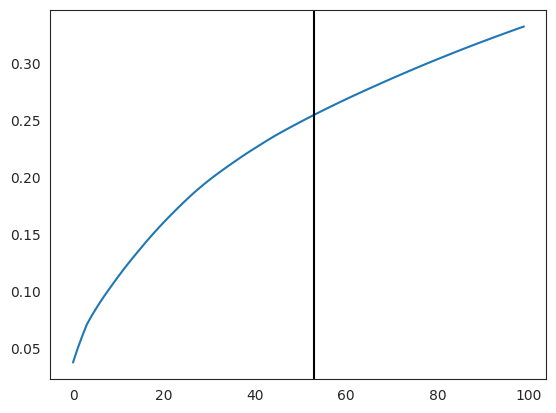

In [27]:
# Select important PCs
plt.plot(np.cumsum(so.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(so.pca.explained_variance_ratio_))>0.002))[0][0]
print(n_comps)

plt.axvline(n_comps, c="k")
plt.show()
n_comps = min(n_comps, 50)

In [28]:
n_cell = so.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :10277
Auto-selected k is :256


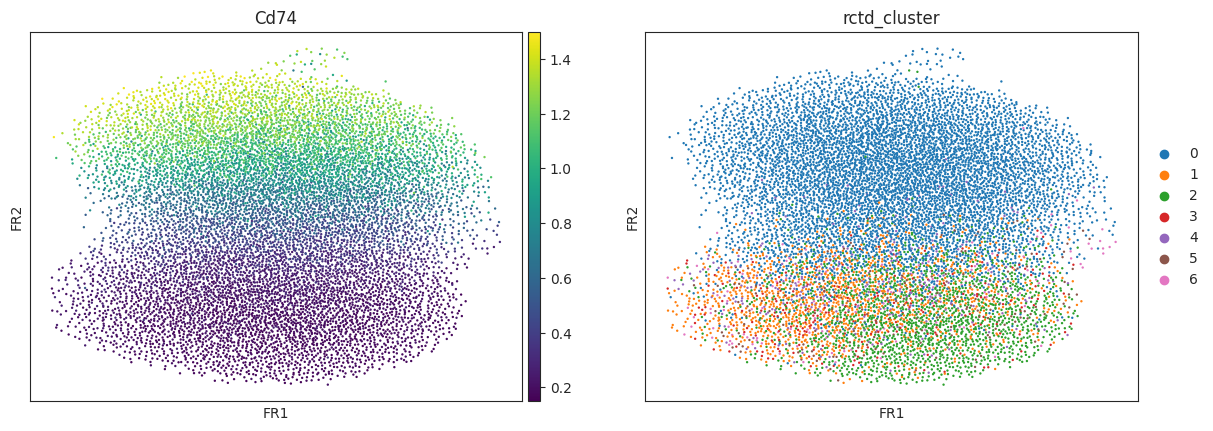

In [29]:
goi = "Cd74"
sc.pl.draw_graph(so.adata, color=[goi, so.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

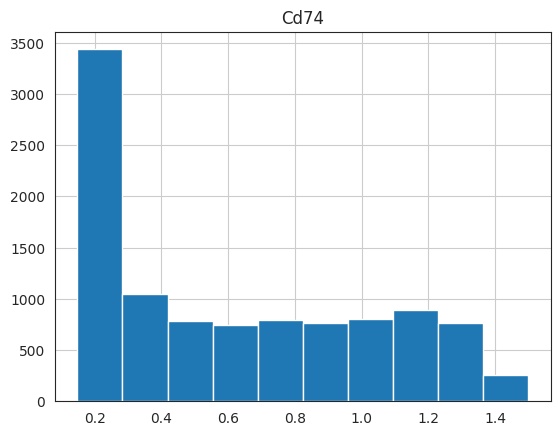

In [30]:
# Plot gene expression in histogram
sc.get.obs_df(so.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [31]:
so.knn_imputation(so.adata, so.pcs, n_pca_dims=n_comps, k=k, balanced=False, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)
                      

In [32]:
# coef_matrix = so.get_coef_matrix(so.adata.copy())
# perturbed_matrix = so.perturb(so.adata.to_df().values, coef_matrix, n_propagation=3)

# so.adata.layers['delta_X'] = so.adata.layers['imputed_count'] - perturbed_matrix
# so.adata.layers['delta_X'].shape

so.simulate_shift(perturb_condition={'Pax5': 0.0})

Running simulation 3/3: 100%|██████████| 10277/10277 [00:59<00:00, 171.45it/s]


In [33]:
so.estimate_transition_prob()

In [34]:
so.calculate_embedding_shift(sigma_corr=0.05)

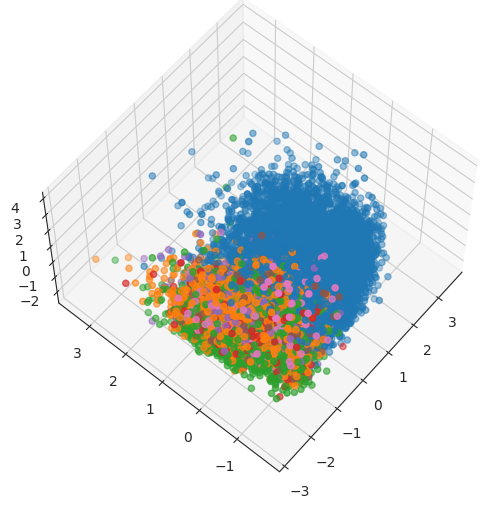

In [35]:
so.plot_pca()

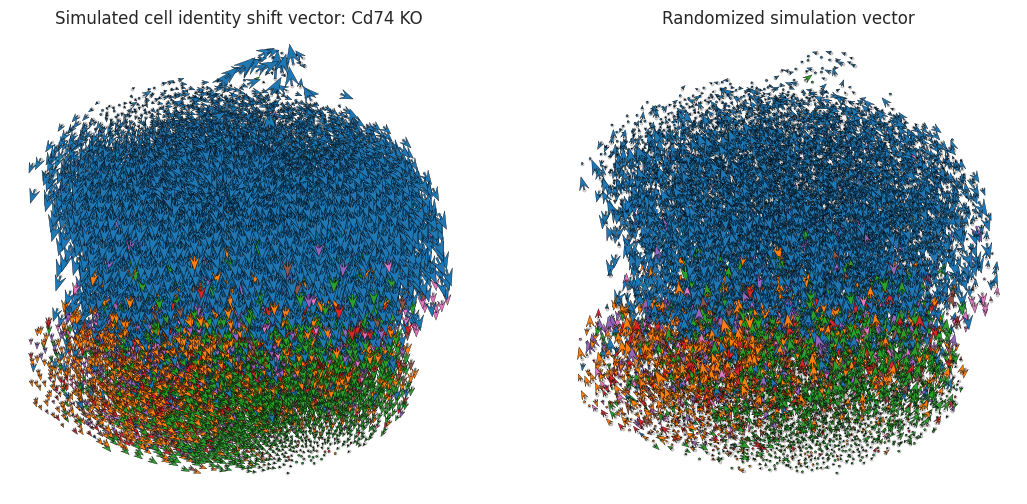

In [36]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
so.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [37]:
# n_grid = 40 is a good starting value.
n_grid = 40
so.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

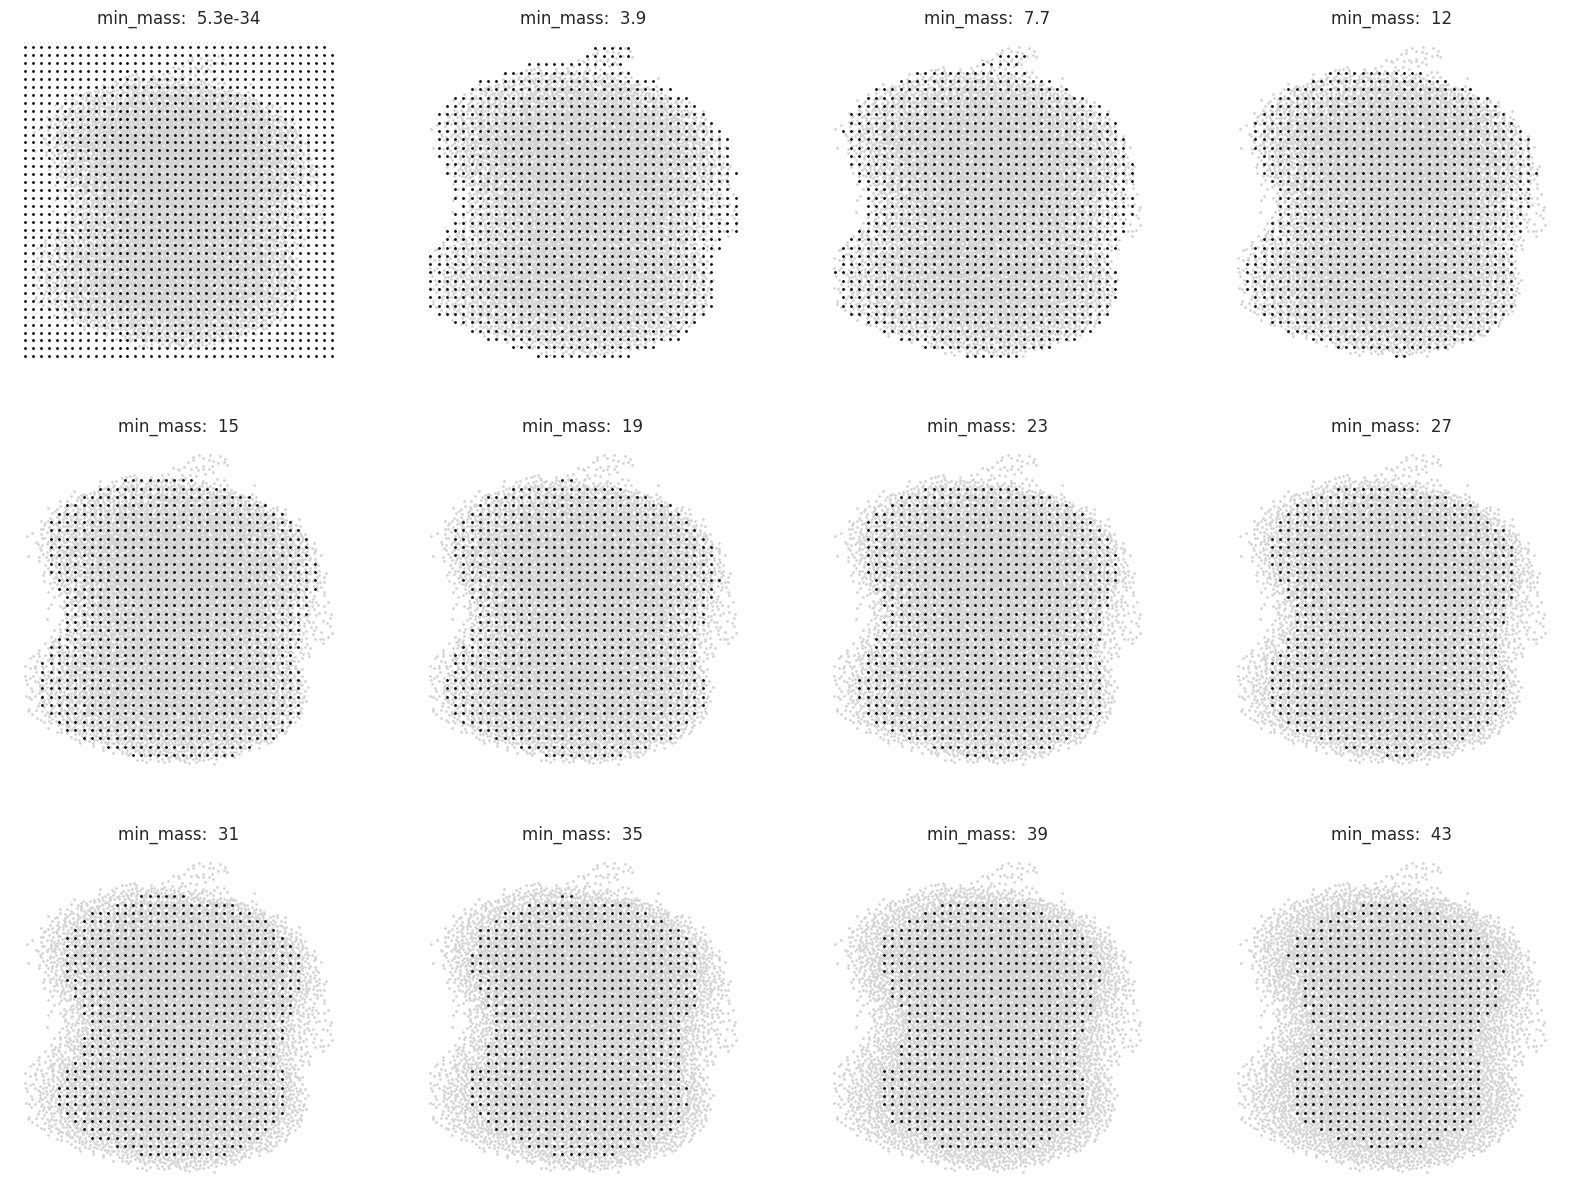

In [38]:
# Search for best min_mass.
so.suggest_mass_thresholds(n_suggestion=12)

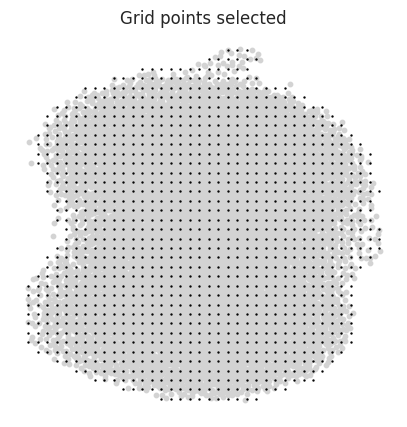

In [39]:
min_mass = 4.2
so.calculate_mass_filter(min_mass=min_mass, plot=True)

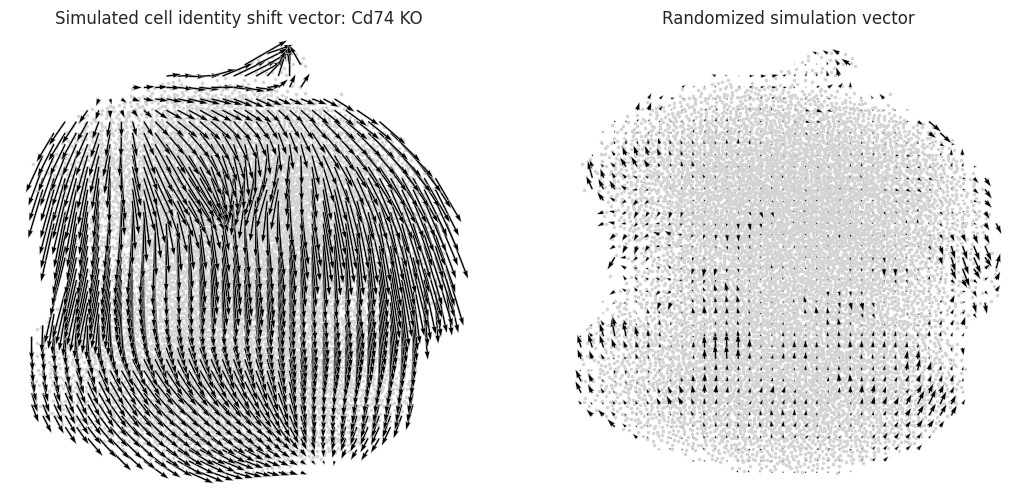

In [40]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 7
# Show quiver plot
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

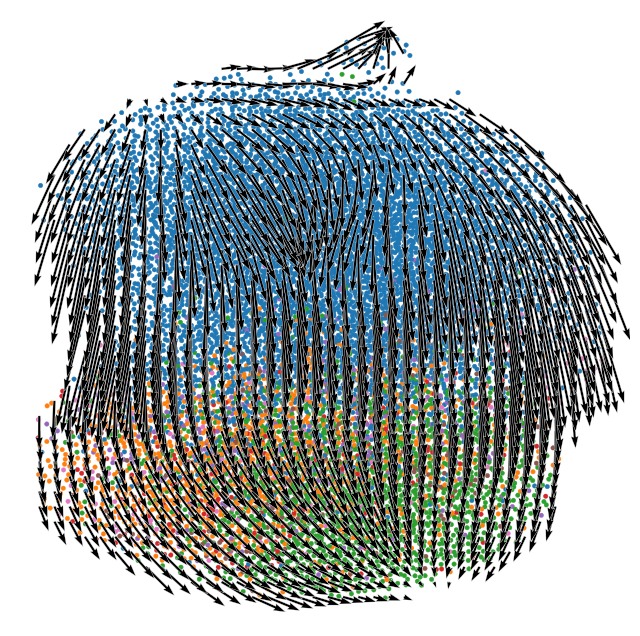

In [41]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

so.plot_cluster_whole(ax=ax, s=10)
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

In [42]:
so.beta_dict.keys()

dict_keys(['Slpi', 'Il9r', 'Znrd1', 'Arhgap42', 'Cx3cr1', 'Nlrc4', 'Trafd1', 'Cxcl9', 'Cep78', 'Rbmx2', 'Trim30b', 'Fstl1', 'Stoml1', 'Heatr6', 'Jam2', 'Vps37a', 'Scyl2', 'Ucp1', 'C4b', 'Fn1', 'Nfib', 'Cox8b', 'Syngr2', 'Tspan17', 'Trim47', 'Stbd1', 'Ephb6', 'Rnf130', 'Aqp1', 'Cwc22', 'Znfx1', 'Acadm', 'Ccdc112', 'Cd300ld', 'Nosip', 'Crim1', 'Paf1', 'Psap', 'Lipe', 'Hspbap1', 'Abcg1', 'Mob3b', 'Zcchc10', '2310039H08Rik', '3830406C13Rik', 'Ube2w', 'Timm44', 'Arl6', 'Zfp839', 'Slc35e4', 'Dnajc3', 'Ptprb', 'Ralgds', 'Lpp', 'Pcp4', 'Sdc4', 'Gbp3', 'Lix1l', 'Itm2c', 'Dcn', 'Ltbr', 'Rwdd4a', 'Ero1lb', 'Mfsd11', 'Igfbp3', 'F13a1', 'Prpf38a', 'Map3k8', 'Mctp2', 'Mtss1', 'Zmym5', 'Casp1', 'Serpina3f', 'Nceh1', 'Cntln', 'Ifi44', '4933421O10Rik', 'Cep170', 'Lrch1', 'Irak2', 'Igf1', 'Cog7', 'Fcrl5', 'Pigq', 'Cpe', 'Dap', 'Wipi2', 'Fah', 'Ttc33', 'H2-Ab1', 'Gnl2', 'Gamt', 'Eapp', 'Prr5', 'Cpxm1', 'Fcer2a', 'Mrps2', 'Ccl17', 'Scly', 'Cd302', 'Aplp2', 'Mrps22', 'Mrc2', 'Ercc1', 'Ift20', 'Osbpl3', 'Ly

In [43]:
so.adata.to_df().shape

(10277, 2833)

In [44]:
so._get_spatial_betas_dict()

Estimating betas globally: 0it [00:00, ?it/s]


{}